# **Surgo Venturs SRS Case Study: COVID-19 Vaccination Likelihood**
### Author: Pushkar Inamdar
#### June 1, 2022

In this notebook, I tried to show how I would go about working through a problem. The goal is to understand a person's chances of getting the COVID-19 Vaccine.  

The provided 2020 sampled survey dataset contains thirty variables with the respondednts sociodemographic characteristics, attituide or beliefs towards COVID vaccine. 

Here is a list of variables. I reorganized the variables with categories in blue.  


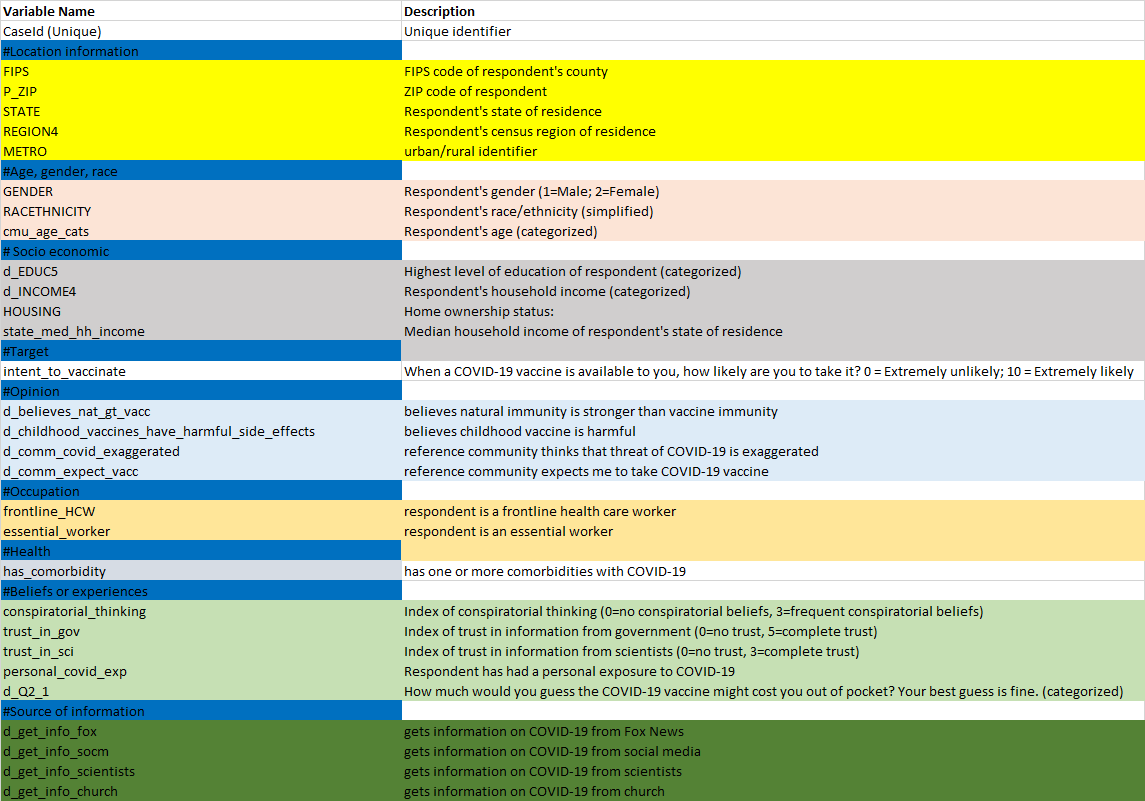

  # Analysis plan
•	Understand nature of the data .info() .describe()
•	Histograms and boxplots 
•	Value counts 
•	Missing data 
•	inferential stats
•	Explore interesting themes 
•	Feature engineering 
•	Feature selection
•	Scaling? Numerical variables
•	Model Baseline 
•	Model comparison with CV


In [1]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [57]:
# Here we import the data
df = pd.read_excel('covid.xlsx')

In [58]:
#Check columns and data shape
df.columns
df.shape

(825, 30)

In [59]:
#quick look at our data types & null counts 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 30 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   CaseId                                          825 non-null    int64  
 1   FIPS                                            812 non-null    float64
 2   P_ZIP                                           812 non-null    float64
 3   GENDER                                          825 non-null    int64  
 4   RACETHNICITY                                    825 non-null    object 
 5   cmu_age_cats                                    816 non-null    object 
 6   d_EDUC5                                         825 non-null    object 
 7   d_INCOME4                                       825 non-null    object 
 8   STATE                                           825 non-null    object 
 9   REGION4                                    

We can see that some values are missining and even for numeric datatype for many categorical features.

# Removing missing data
As the % missingness is small, I decide to drop entire rows to save time. But we can interpolate those values based on neighborhood models or descriptive stats.


In [60]:
# Removed missing values
df.isnull().mean()
df.dropna(inplace=True)
df.shape

(777, 30)

 # Feature Engineering
We can see that many categorical variables have a numeric data type. So here I changed the data types.

In [61]:
#Changin data types
categories=['FIPS', 'P_ZIP', 'GENDER', 'RACETHNICITY', 'cmu_age_cats',
       'd_EDUC5', 'd_INCOME4', 'STATE', 'REGION4', 'METRO', 'HOUSING',
       'intent_to_vaccinate', 'd_believes_nat_gt_vacc',
       'd_childhood_vaccines_have_harmful_side_effects',
       'd_comm_covid_exaggerated', 'd_comm_expect_vacc', 'frontline_HCW',
       'essential_worker', 'has_comorbidity', 'conspiratorial_thinking',
       'trust_in_gov', 'trust_in_sci', 'personal_covid_exp',
        'd_Q2_1', 'd_get_info_fox', 'd_get_info_socm',
       'd_get_info_scientists', 'd_get_info_church']

for col_name in categories:
  df[col_name] = df[col_name].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777 entries, 0 to 824
Data columns (total 30 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   CaseId                                          777 non-null    int64   
 1   FIPS                                            777 non-null    category
 2   P_ZIP                                           777 non-null    category
 3   GENDER                                          777 non-null    category
 4   RACETHNICITY                                    777 non-null    category
 5   cmu_age_cats                                    777 non-null    category
 6   d_EDUC5                                         777 non-null    category
 7   d_INCOME4                                       777 non-null    category
 8   STATE                                           777 non-null    category
 9   REGION4                         


Here I created new binary variable from intent_to_vaccinate. This is done by recoding original **0-5** categories to **0** and **6-10** to **1**. Where **0 = Intent to take vaccine is extremely unlikely; 1 = Intent to take vaccine is extremely likely**

I assumed categories 99, 77, and 98 are errors: removed 3 records from the data.

This binary variable solves unbalanaced target variable problem.

**Note: Dividing the intent into 3 classes might result better i.e "extremely unlikely", "Not sure","extremely likely" in ML models. But to simplify plotting and interpretation, I'm using a binary variable**


In [69]:
# creating binary intent variabl
intent = [0,1,2,3,4,5,6,7,8,9,10,99,77,98]
binary_intent = [0,0,0,0,0,0,1,1,1,1,1,99,99,99]

df['binary_intent'] = df['intent_to_vaccinate'].replace(intent, binary_intent)

df=df[df.binary_intent!=99]

# Brief Data Exploration
1) For numeric data:
Made histograms to understand distribution.
Used box-cox to make it close to normal distribution.
Pivot table comparing intent to vaccinate.

2) For Categorical Data: 
Made bar charts to understand balance of classes.
Made pivot tables to understand relationship with intent to vaccinate.

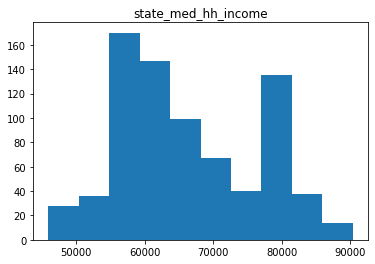

In [63]:
#distributions for all numeric variables 
plt.hist(df['state_med_hh_income'])
plt.title('state_med_hh_income')
plt.show()

# Inferential Stats

H0: No difference in HH income based on the binary intent
H1: There is a difference in the HH income based on the binary intent

Statistically we can see there is not much difference in HH income values.

In [73]:

# Inferential Statistics
import scipy.stats as stats
from scipy.stats import ttest_ind

df.state_med_hh_income.groupby(df.binary_intent).mean()

Unlinkely=df[df.binary_intent==0]
likely=df[df.binary_intent==1]

ttest_ind(Unlinkely.state_med_hh_income,likely.state_med_hh_income,equal_var=False)

Ttest_indResult(statistic=-0.07518368250454896, pvalue=0.940088763919518)

Box-Cox transformation transforms state_med_hh_income. So that it closely resembles a normal distribution.

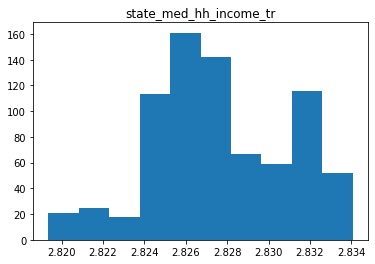

In [64]:
# Box cox transformation
df['state_med_hh_income_1'] = stats.boxcox(df['state_med_hh_income'])[0]
#distributions for all numeric variables 
plt.hist(df['state_med_hh_income_1'])
plt.title('state_med_hh_income_tr')
plt.show()

In [65]:
#Pivot analyses
pd.pivot_table(df, index = ['intent_to_vaccinate'], values = ['state_med_hh_income'],aggfunc=['mean','count'])

,mean,count
,state_med_hh_income,state_med_hh_income
intent_to_vaccinate,,
0,65797.417266,139
1,69885.038462,26
2,65475.551724,29
3,66218.585366,41
4,68213.062500,32
5,66627.142857,77
6,67485.156250,32
7,69344.547170,53


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


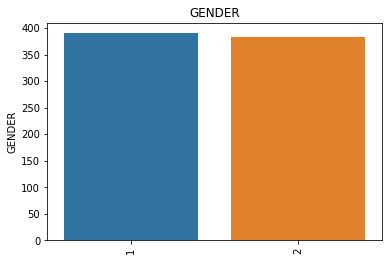

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


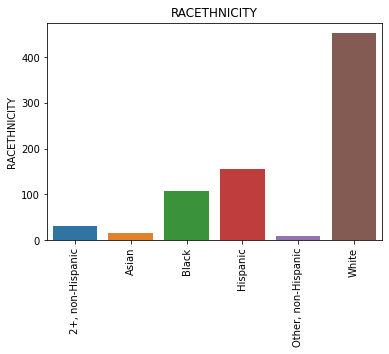

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


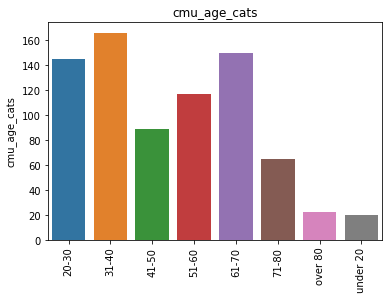

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


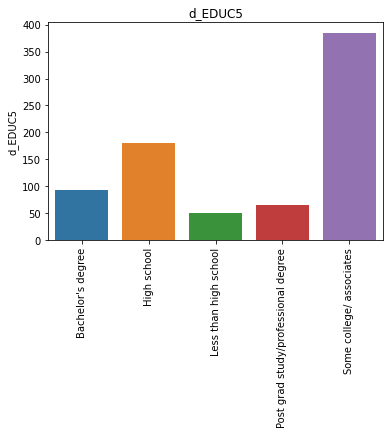

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


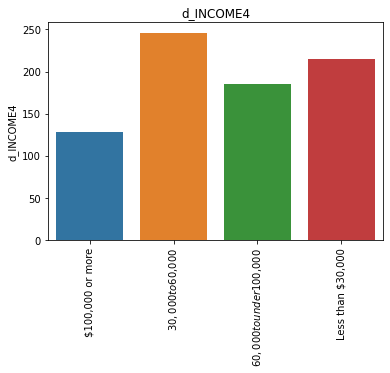

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


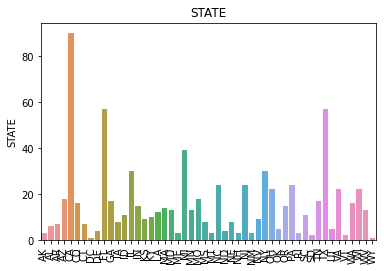

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


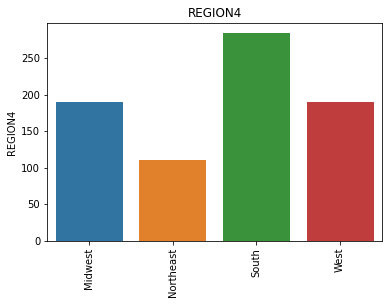

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


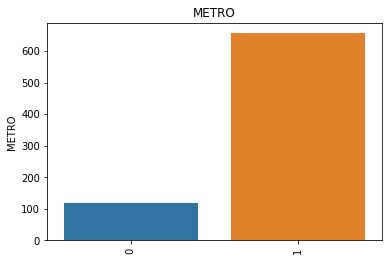

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


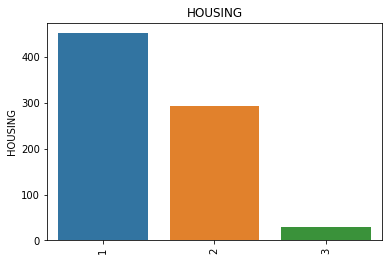

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


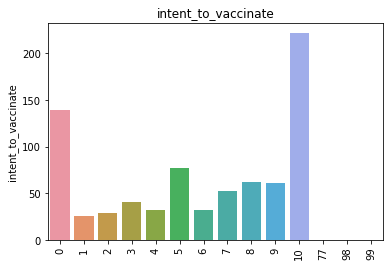

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


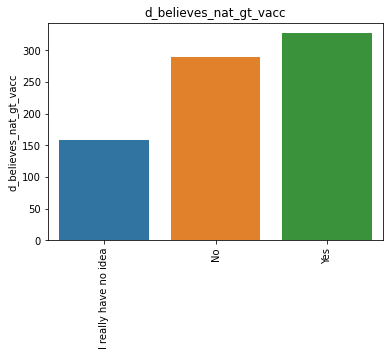

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


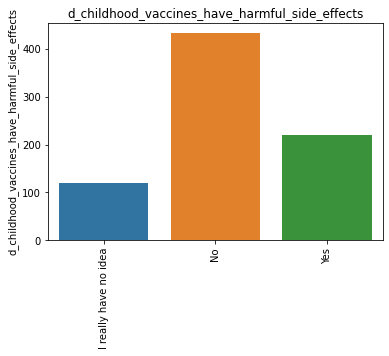

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


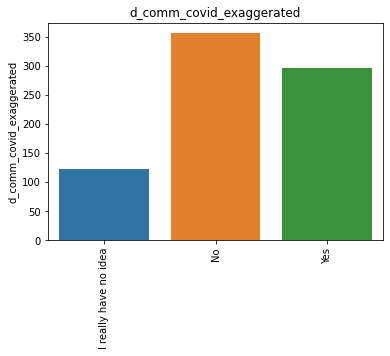

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


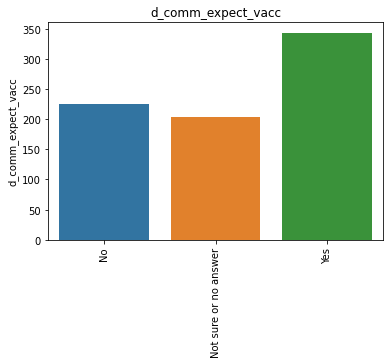

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


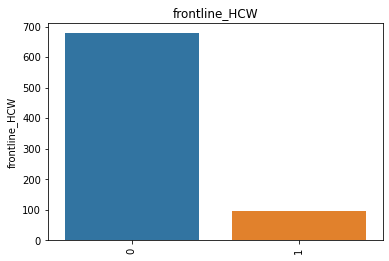

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


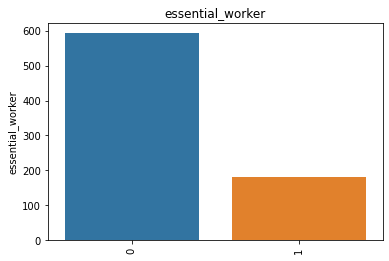

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


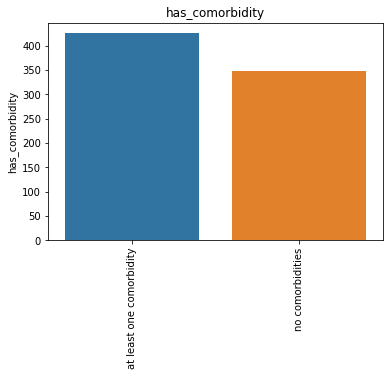

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


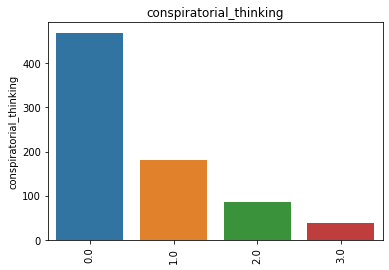

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


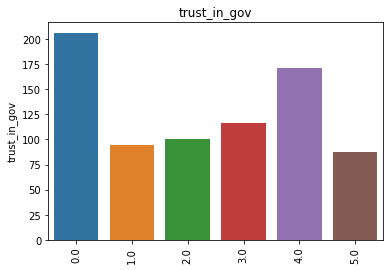

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


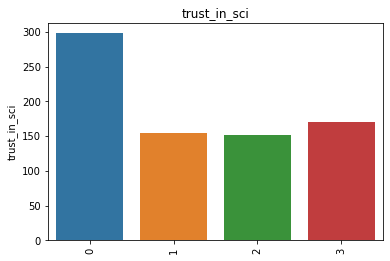

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


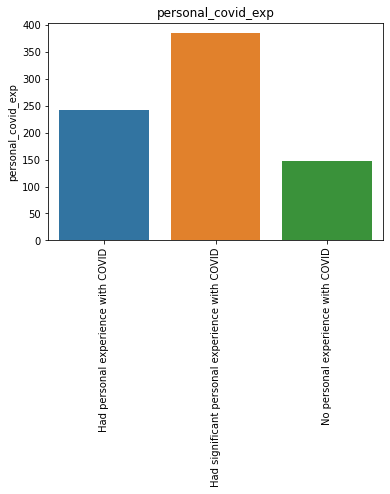

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


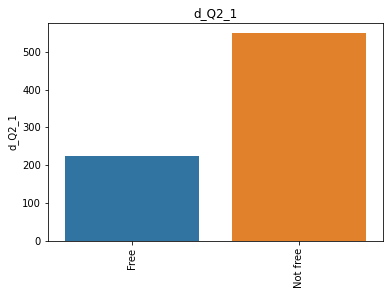

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


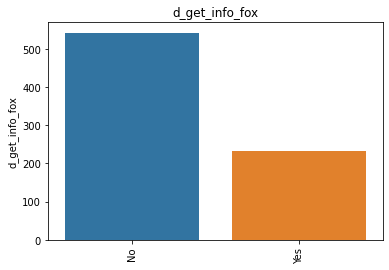

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


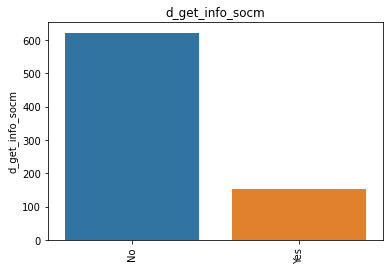

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


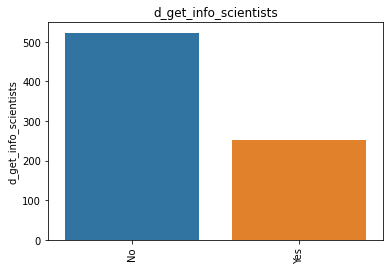

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


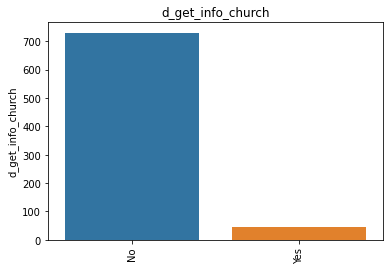

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


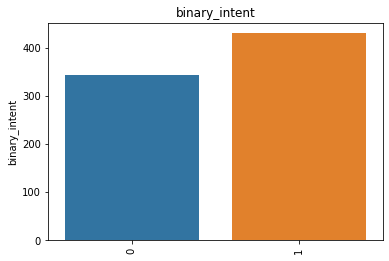

In [66]:
# Making barplots for categorical variables
categories=['GENDER', 'RACETHNICITY', 'cmu_age_cats',
       'd_EDUC5', 'd_INCOME4', 'STATE', 'REGION4', 'METRO', 'HOUSING',
       'intent_to_vaccinate', 'd_believes_nat_gt_vacc',
       'd_childhood_vaccines_have_harmful_side_effects',
       'd_comm_covid_exaggerated', 'd_comm_expect_vacc', 'frontline_HCW',
       'essential_worker', 'has_comorbidity', 'conspiratorial_thinking',
       'trust_in_gov', 'trust_in_sci', 'personal_covid_exp',
        'd_Q2_1', 'd_get_info_fox', 'd_get_info_socm',
       'd_get_info_scientists', 'd_get_info_church','binary_intent']
for i in categories:
    sns.barplot(df[i].value_counts().index,df[i].value_counts()).set_title(i)
    plt.xticks(rotation=90)
    plt.show()

These plots tell us about individual distribution. 


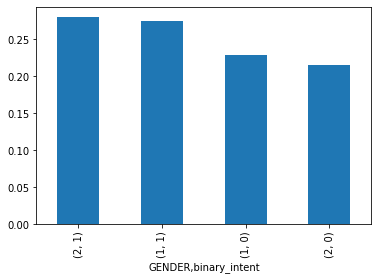

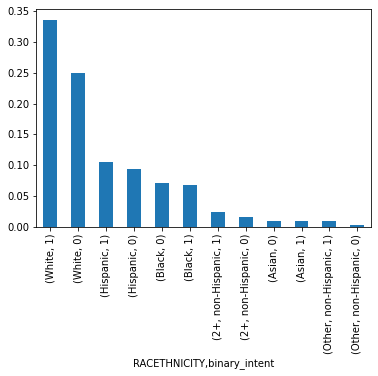

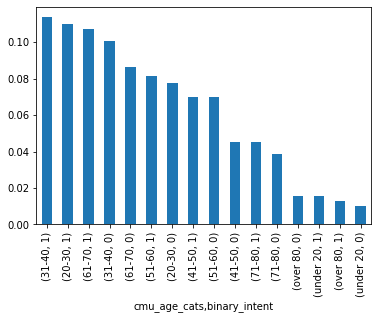

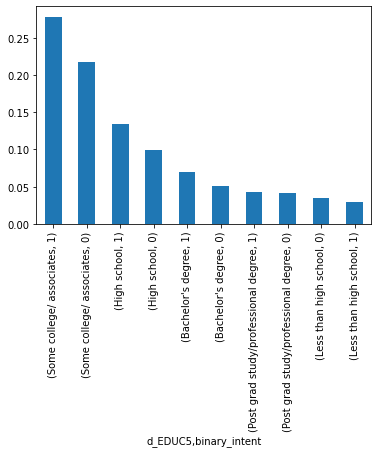

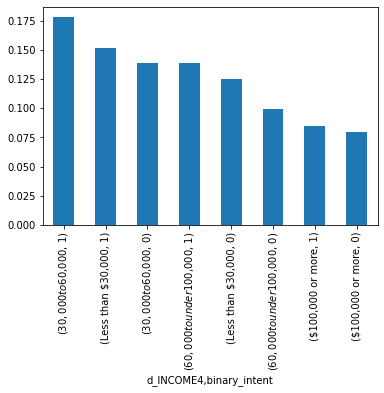

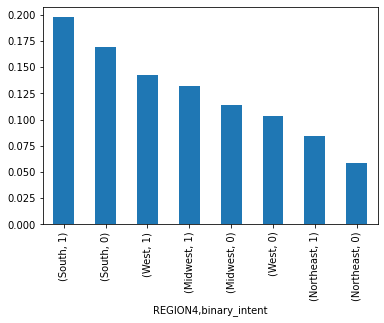

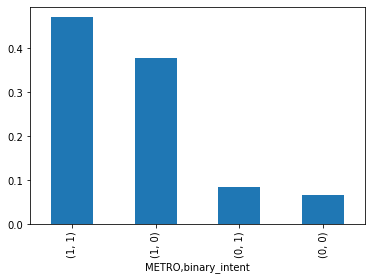

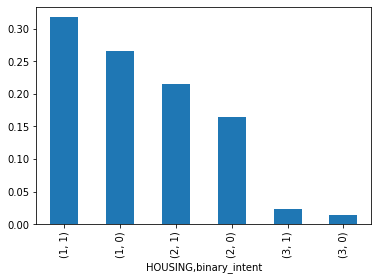

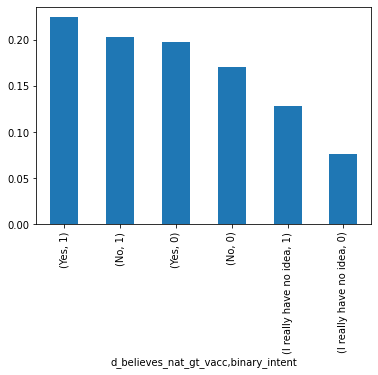

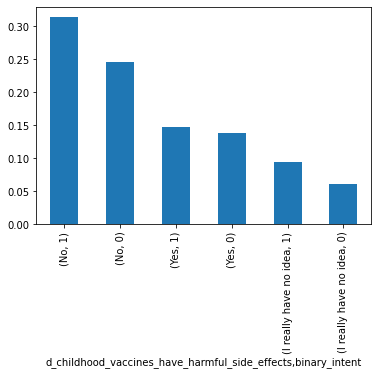

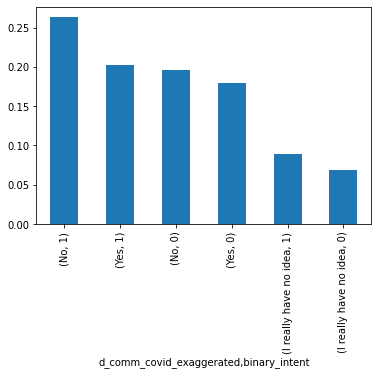

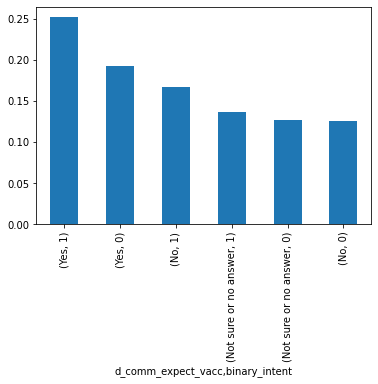

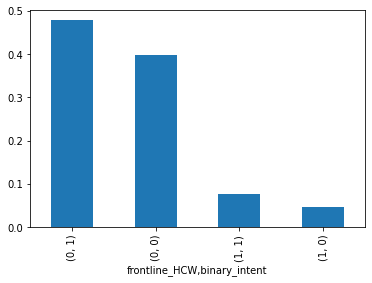

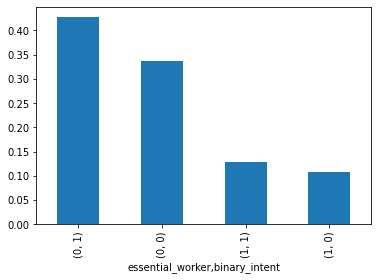

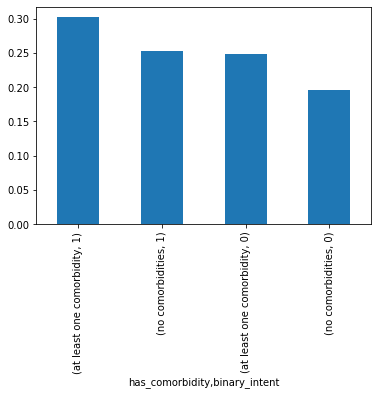

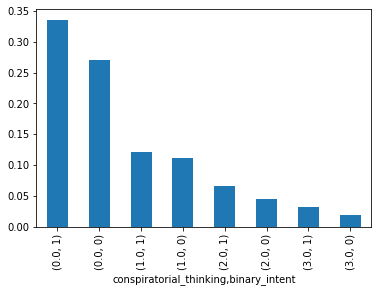

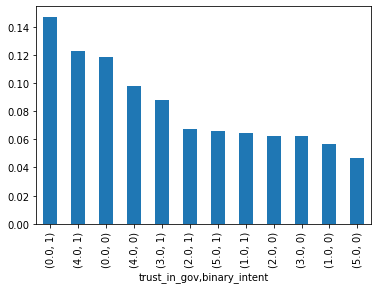

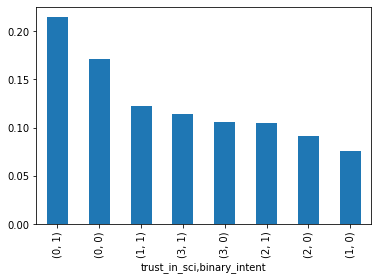

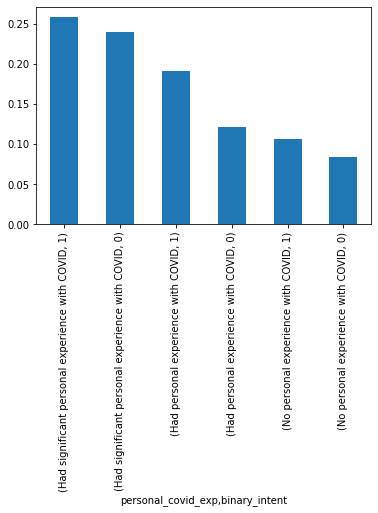

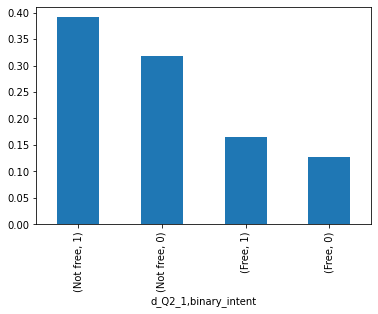

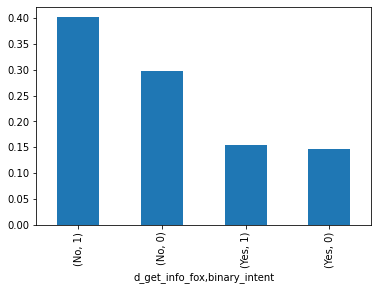

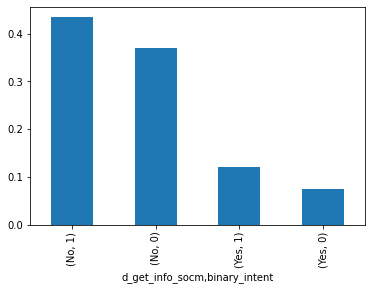

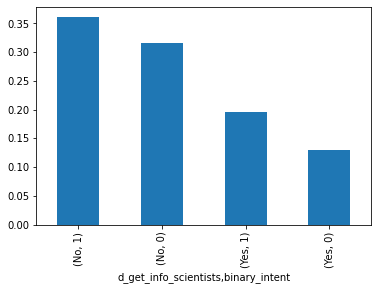

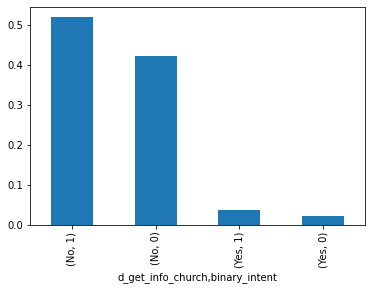

In [75]:
# comparison of individual catagorical varables with intent_to_vaccine binary variable
categories=['GENDER', 'RACETHNICITY', 'cmu_age_cats',
       'd_EDUC5', 'd_INCOME4', 'REGION4', 'METRO', 'HOUSING', 'd_believes_nat_gt_vacc',
       'd_childhood_vaccines_have_harmful_side_effects',
       'd_comm_covid_exaggerated', 'd_comm_expect_vacc', 'frontline_HCW',
       'essential_worker', 'has_comorbidity', 'conspiratorial_thinking',
       'trust_in_gov', 'trust_in_sci', 'personal_covid_exp',
        'd_Q2_1', 'd_get_info_fox', 'd_get_info_socm',
       'd_get_info_scientists', 'd_get_info_church']

for i in categories:
    df[[i,'binary_intent']].value_counts(normalize=True).plot(kind='bar')
    plt.xticks(rotation=90)
    plt.show()

## These plots help understand the relationship between each categorical variable and the intent to vaccinate variable. 

**Note these trends are affected by population. But I still used it to understand the data.**

### Age and intent
There is no clear trend in the age category. But it is interesting to see old and young age groups not inclined towards vaccination.

### Gender and intent
There is not much difference between Male VS females.

### Signigican experice and intent 
Shows a clear trend, those with more experience more likely to be vaccinated

## Education and intent
Interestingly post graduates % is less than undergraduates. But otherwise educated people are interested in the covid vaccine. 

## comorbidity and work information
Shows inclination towards vaccine

I will explore others using the RF model

 









# **Feature Selection**

Feature Selection is the process where we can automatically or manually select those features that contribute most to intent to vaccinate.

Here I used random forest classifier, to select top performing features. 



In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

# encoding the levels of categorical features into numeric values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cols = df.columns.tolist()
for column in cols:
    if df[column].dtype == 'category':
        df[column] = le.fit_transform(df[column])

X = df.drop(['binary_intent','CaseId','state_med_hh_income','intent_to_vaccinate'], 1)       # feature matrix
y = df['binary_intent']               # target feature

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42,test_size =0.20,stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape) 

(619, 28)
(155, 28)
(619,)
(155,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  



# **Finding best parameters**

To select the best parameters from the listed hyperparameters, I used 
GridSearchCV is a library function. It helps to loop through predefined hyperparameters and fit estimator (model) on the training set.

In [174]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

In [176]:
# Best parameters used for the model selection
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200}

In [13]:
# model with the best paramteres
rf_w = RandomForestClassifier(bootstrap=True,max_depth=80,max_features=2,min_samples_leaf=4,min_samples_split=10, n_estimators=200)
rf_w.fit(X_train, y_train)
y_pred_rf_w = rf_w.predict(X_test)

#In classification, this function computes subset accuracy: 
#the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

# accuracy of the model
metrics.accuracy_score(y_test,y_pred_rf_w)

0.5548387096774193

In this case, model accuracy found to be between 50 and 56%. That means: ~55% of the predicted labels (intent to vaccinate) by the current model match with true value. 


# Plot the feature importances in bars.

Here goal is to see which features are contributing more in determinig likelihood of intent. It is important to note that model accuracy is not great. There is scope for lot of improvement. Due to limited time for the analysis, I will select important features based on this base model only. 

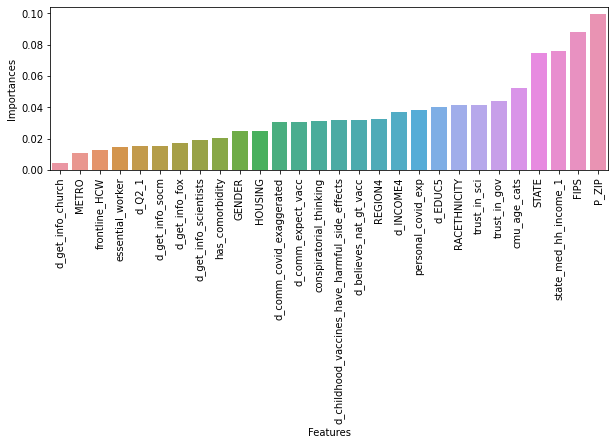

In [14]:
# get the importance of the resulting features.
importances = rf_w.feature_importances_
# create a data frame for visualization.
final_df = pd.DataFrame({"Features": X_train.columns, "Importances":importances})
final_df.set_index('Importances')

# sort in ascending order to better visualization.
final_df = final_df.sort_values('Importances')

# plot the feature importances in bars.
plt.figure(figsize=(10,3))
plt.xticks(rotation=90)
sns.barplot(x="Features",y= "Importances", data=final_df)

In [33]:
# Here I used cutoff value >0.029 
final_list=final_df.sort_values(by=['Importances'], ascending=False).head(17)
final_list.Features
final_df=df[["P_ZIP","FIPS","state_med_hh_income_1","STATE","cmu_age_cats","trust_in_gov","trust_in_sci","RACETHNICITY",
"personal_covid_exp","d_INCOME4","REGION4","d_believes_nat_gt_vacc","d_childhood_vaccines_have_harmful_side_effects","conspiratorial_thinking","d_comm_expect_vacc",
"d_comm_covid_exaggerated","binary_intent"]]

# Model Building (Baseline Validation Performance)
Before going further, I like to see how  different models perform with default parameters. I tried the following models using 5 fold cross validation to get a baseline. 

With a validation set basline, we can see how much tuning improves each of the models. Just because a model has a high basline on this validation set doesn't mean that it will actually do better on the eventual test set.

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [36]:
X = final_df.drop(['binary_intent'], 1)       # feature matrix
y = final_df['binary_intent']               # target feature

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42,test_size =0.20,stratify=y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [37]:
#Naive Bayes as a baseline  
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.52419355 0.5483871  0.51612903 0.53225806 0.52845528]
0.5298846052976659


In [38]:
# logistic regression
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.50806452 0.52419355 0.56451613 0.56451613 0.53658537]
0.5395751376868607


In [39]:
# tree models
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.49193548 0.48387097 0.5483871  0.52419355 0.48780488]
0.5072383949645948


In [40]:
#K nearest neighbor
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.55645161 0.51612903 0.49193548 0.53225806 0.59349593]
0.5380540257015474


In [41]:
# Random forest
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.49193548 0.56451613 0.49193548 0.47580645 0.56097561]
0.5170338316286389


In [42]:
# support vector machines
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.55645161 0.55645161 0.55645161 0.55645161 0.55284553]
0.5557303960136375


In [43]:
# boosted classifier
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.50806452 0.49193548 0.49193548 0.53225806 0.54471545]
0.5137817991083138


#Voting classifier 
Takes all of the inputs and averages the results. For a "hard" voting classifier each classifier gets 1 vote "yes" or "no" and the result is just a popular vote. For this, you generally want odd numbers

"soft" classifier averages the confidence of each of the models. If a the average confidence is > 50% that it is a 1 it will be counted as such

In [44]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)], voting = 'soft') 

In [46]:
cv = cross_val_score(voting_clf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.56451613 0.54032258 0.53225806 0.52419355 0.5203252 ]
0.5363231051665356


# Model Tuned Performance
After getting the baselines, let's see if we can improve on the indivdual model results!I mainly used grid search to tune the models. I only used best performing baseline models SVC, logistic regression, and KNN to save testing time.

In [49]:
from sklearn.model_selection import GridSearchCV 
#Performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [51]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 2, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train,y_train)
clf_performance(best_clf_svc,'SVC')

Fitting 2 folds for each of 45 candidates, totalling 90 fits
SVC
Best Score: 0.5831976197932978
Best Parameters: {'C': 0.1, 'kernel': 'linear'}


In [54]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 2, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 2 folds for each of 40 candidates, totalling 80 fits
Logistic Regression
Best Score: 0.583192400041758
Best Parameters: {'C': 0.012742749857031334, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}


In [53]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 2, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train,y_train)
clf_performance(best_clf_knn,'KNN')

Fitting 2 folds for each of 36 candidates, totalling 72 fits
KNN
Best Score: 0.5234158054076625
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 2, 'weights': 'distance'}


# Write 1 paragraph you might put in a put in a peer-reviewed paper interpreting the model's relevant performance metrics.

This study focuses on how a persons environment and beliefs affect their willingness to take the COVID-19 vaccine. People bear several reservations, but overall suervey sample population show inclination towards getting the COVID-19 vaccine. Geographic locations (FIPS, ZIP, State), Median household income,  Education, Age, Race and Trust (on goverment, Scientists) appears to be the key determinants of vaccination intent. Among others, beliefs and personal experiences are ranked higher within Random Forest model. 
This study intends to estimate what drives the perception of the masses towards COVID-19 vaccination. Six models, e.g., Naive Bayes, random forest (RF), a support vector machine (SVM), decision tree (DT), K-nearest neighbor (KNN), and eXtreme Gradient Boosting (XGboost), were used for forecasting the overall predilection toward the COVID-19 vaccine. A voting classifier was used at the end of this study to determine the accuracy of all the classifiers. The results prove that the SVM and Logit model after hyperparameter tuning produces the best forecasting results (accuracy: 52%) and that KNN (accuracy: 52%) did not improve much after tuning and produced the worst prediction toward the intent to be vaccinated by the COVID-19 vaccine. When using the voting classifier, the proposed system provided an overall accuracy of 56%. 

Thus, the results show that the studied prediction technique is a promising, with improvements feature engineering and additonal supporting data to propose coverage-enhancing policy responses.

 

# What is your recommendation regarding putting the model in production? How should it be used?

In my opinion, having a model with consistently good performance (at least 80% or more -accuracy/f1 score) is essential for production. As the metrics show that the current model is not performing well (accuracy obtained after tuning SVC: ~59%), I would not recommend putting the model in production.  

Without consistent performance, we will not be able to set up the tests to determine if the model is behaving as expected. I recommend improving the current model by adding new data, thorough feature engineering, and parameter tuning. 


# What additional data would augment this exercise if available? Why is it important? How would you source it? What analyses would you run on it?

I would integrate deprivation measures derived from census data. As, the knowledge of socioeconomic characteristics of neighborhoods is necessary to identify unique health needs and enhance the identification of socioeconomically disadvantaged populations.

Also, in addition, I would augment data derived from sentiment analysis. It is classification of the sentiments that are expressed in the text source example Twitter. This data wold be helpful in understanding the opinion of the people about a variety of topics related to COVID vaccine.

